
# Experiment 3 — LoRA Adapters + Bayesian Approximation (Laplace/Fisher) for 3‑way MCQ

**Goal.** Start from a small pretrained text encoder, add **LoRA adapters** to a few attention/projection modules, fine‑tune only those adapters on a **3‑option multiple‑choice** task, then place a **Bayesian posterior** over the *adapter parameters* using a simple **diagonal Laplace / Fisher approximation**.

**Why this is nice (for education + speed):**
- We avoid sampling full Transformer weights. We only adapt a tiny set of parameters (LoRA).
- After fine‑tuning, we build a Gaussian posterior around the MAP solution using the **empirical Fisher diagonal** (i.e., squared gradients under the data).
- Posterior predictive = **Monte Carlo average** over a few draws of adapter weights.
- We can then plot the same **calibration** and **abstention** figures as in the previous experiments.



## 0) Setup

Install (inside your Pipenv or environment):
```bash
pipenv run pip install "torch>=2.2" transformers peft accelerate datasets     scikit-learn pandas matplotlib numpy tqdm
```
> On Apple Silicon without GPU, this runs on CPU and is fine for small models.



## 1) Data — 3‑option MCQ
Expecting a pandas DataFrame `df` with columns:
- `question`, `option_a`, `option_b`, `option_c`, `label` (0,1,2)

Below we create a small default dataset if `df` is not defined yet.


In [108]:

import pandas as pd

if 'df' not in globals():
    rows = [
        # label 0
        {"question": "Which planet is known as the Red Planet?", "option_a": "Mars", "option_b": "Venus", "option_c": "Jupiter", "label": 0},
        {"question": "Capital of France?", "option_a": "Paris", "option_b": "Berlin", "option_c": "Madrid", "label": 0},
        {"question": "Which animal barks?", "option_a": "dog", "option_b": "cat", "option_c": "cow", "label": 0},
        {"question": "Which country hosted the 2016 Summer Olympics?", "option_a": "Brazil", "option_b": "China", "option_c": "UK", "label": 0},
        {"question": "Who discovered penicillin?", "option_a": "Alexander Fleming", "option_b": "Marie Curie", "option_c": "Louis Pasteur", "label": 0},
        {"question": "What is the capital of Japan?", "option_a": "Kyoto", "option_b": "Tokyo", "option_c": "Osaka", "label": 0},
        {"question": "Which is the fastest land animal?", "option_a": "Cheetah", "option_b": "Horse", "option_c": "Lion", "label": 0},
        {"question": "Who wrote 'Romeo and Juliet'?", "option_a": "William Shakespeare", "option_b": "Charles Dickens", "option_c": "Mark Twain", "label": 0},
        {"question": "Which gas is essential for respiration?", "option_a": "Oxygen", "option_b": "Carbon monoxide", "option_c": "Helium", "label": 0},
        {"question": "Which continent is Egypt located in?", "option_a": "Africa", "option_b": "Asia", "option_c": "Europe", "label": 0},
        # label 1
        {"question": "What color are bananas when ripe?", "option_a": "red", "option_b": "yellow", "option_c": "blue", "label": 1},
        {"question": "How many continents are there?", "option_a": "Five", "option_b": "Seven", "option_c": "Six", "label": 1},
        {"question": "Who painted the Mona Lisa?", "option_a": "Michelangelo", "option_b": "Leonardo da Vinci", "option_c": "Raphael", "label": 1},
        {"question": "What is the boiling point of water at sea level (°C)?", "option_a": "90", "option_b": "100", "option_c": "110", "label": 1},
        {"question": "2 + 2 equals?", "option_a": "3", "option_b": "4", "option_c": "5", "label": 1},
        {"question": "How many players are on a standard soccer team (on field)?", "option_a": "9", "option_b": "11", "option_c": "12", "label": 1},
        {"question": "Which element has the symbol 'O'?", "option_a": "Osmium", "option_b": "Oxygen", "option_c": "Gold", "label": 1},
        {"question": "Which shape has three sides?", "option_a": "Square", "option_b": "Triangle", "option_c": "Pentagon", "label": 1},
        {"question": "What is the largest mammal?", "option_a": "Elephant", "option_b": "Blue Whale", "option_c": "Giraffe", "label": 1},
        {"question": "Which ocean is the largest?", "option_a": "Pacific Ocean", "option_b": "Atlantic Ocean", "option_c": "Indian Ocean", "label": 1},
        # label 2
        {"question": "Which organ pumps blood in the human body?", "option_a": "Lungs", "option_b": "Brain", "option_c": "Heart", "label": 2},
        {"question": "The Sun is a ...", "option_a": "planet", "option_b": "comet", "option_c": "star", "label": 2},
        {"question": "Which metal is liquid at room temperature?", "option_a": "Mercury", "option_b": "Iron", "option_c": "Aluminum", "label": 2},
        {"question": "The Great Wall is located in which country?", "option_a": "India", "option_b": "China", "option_c": "Japan", "label": 2},
        {"question": "Which planet has the most moons?", "option_a": "Jupiter", "option_b": "Saturn", "option_c": "Neptune", "label": 2},
        {"question": "Which gas do humans exhale?", "option_a": "Oxygen", "option_b": "Carbon dioxide", "option_c": "Nitrogen", "label": 2},
        {"question": "Which city is known as the Big Apple?", "option_a": "New York", "option_b": "Los Angeles", "option_c": "Chicago", "label": 0},
        {"question": "Which country is both in Europe and Asia?", "option_a": "Turkey", "option_b": "Spain", "option_c": "Mexico", "label": 0},
        {"question": "Which month has 28 days?", "option_a": "February", "option_b": "June", "option_c": "November", "label": 0},
        {"question": "What is the chemical symbol for gold?", "option_a": "Ag", "option_b": "Au", "option_c": "Pb", "label": 1},
    ]
    df = pd.DataFrame(rows)

df.head()


,question,option_a,option_b,option_c,label
0,Which planet is known as the Red Planet?,Mars,Venus,Jupiter,0
1,Capital of France?,Paris,Berlin,Madrid,0
2,Which animal barks?,dog,cat,cow,0
3,Which country hosted the 2016 Summer Olympics?,Brazil,China,UK,0
4,Who discovered penicillin?,Alexander Fleming,Marie Curie,Louis Pasteur,0



## 2) Split


In [109]:

from sklearn.model_selection import train_test_split
import numpy as np

y = df['label'].values.astype(int)
train_df, test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=y if len(np.unique(y))>1 else None)
len(train_df), len(test_df)


(18, 12)


## 3) Model — Tiny encoder + LoRA adapters

We use a **very small** encoder to keep it fast (e.g., `prajjwal1/bert-tiny`). We score each (question, option) pair separately, then **softmax across the 3 options**.


In [113]:

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model, TaskType

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "prajjwal1/bert-tiny"  # small & fast
#model_name = "microsoft/MiniLM-L12-H384-uncased"
#model_name = "prajjwal1/bert-small"

tok = AutoTokenizer.from_pretrained(model_name)
base = AutoModel.from_pretrained(model_name).to(device)
base.eval()

# Freeze base model
for p in base.parameters():
    p.requires_grad_(False)

# Attach LoRA to attention projections (keys vary by model; this works for BERT-like)
lora_cfg = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=16,              # was 8
    lora_alpha=32,     # scale with r
    lora_dropout=0.05,
    target_modules=["query", "key", "value", "dense"],
    bias="none",
)
base_lora = get_peft_model(base, lora_cfg).to(device)
base_lora.train()

# Lightweight classification head on top of [CLS]
hidden = base.config.hidden_size
head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(base.config.hidden_size, 1, bias=True)
).to(device)
# nn.init.zeros_(head.bias)



## 4) Dataloaders — turn MCQ into pairwise inputs

Each example yields 3 encodings: (question, option_a/b/c) → we get [CLS] and score each separately.


In [114]:

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class MCQPairs(Dataset):
    def __init__(self, frame, tokenizer, max_length=128):
        self.rows = frame.reset_index(drop=True)
        self.tok = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows.iloc[idx]
        q = str(r["question"])
        opts = [str(r["option_a"]), str(r["option_b"]), str(r["option_c"])]
        label = int(r["label"])
        return q, opts, label

def collate(batch):
    qs, opts_list, labels = zip(*batch)
    pairs = []
    opt_pos = []  # 0 for A, 1 for B, 2 for C
    map_indices = []  # which original item this pair belongs to

    for i, (q, opts) in enumerate(zip(qs, opts_list)):
        for j, a in enumerate(opts):
            pairs.append((q, a))
            opt_pos.append(j)
            map_indices.append(i)

    enc_be = tok([q for q, a in pairs],
                 [a for q, a in pairs],
                 truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)

    allowed = {"input_ids","attention_mask","token_type_ids"}
    enc = {k: v for k, v in dict(enc_be).items() if k in allowed and v is not None}

    return enc, torch.tensor(map_indices, dtype=torch.long), torch.tensor(opt_pos, dtype=torch.long), torch.tensor(labels, dtype=torch.long)

train_ds = MCQPairs(train_df, tok)
test_ds  = MCQPairs(test_df, tok)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, collate_fn=collate)



## 5) Fine‑tune LoRA adapters (MAP estimate)

We optimize only **LoRA adapter params** and the **linear head**, with cross‑entropy over the 3 options.


In [116]:
# ==== TRAINING LOOP (inline, robust regrouping) ====

import torch
from torch import nn
from tqdm import tqdm

# ===== Optional last-layer unfreeze (default: keep frozen) =====

UNFREEZE_LAST = False  # <- set True to fine-tune the last transformer block

# Detect last encoder layer index (works for bert-tiny, -small, etc.)
last_idx = getattr(base.config, "num_hidden_layers", 2) - 1  # bert-tiny: 2 -> last_idx=1
layer_tag = f"encoder.layer.{last_idx}."

# Freeze everything in the base by default (you likely already did this above)
for p in base.parameters():
    p.requires_grad_(False)

# LoRA params are already trainable. Optionally unfreeze last encoder layer:
if UNFREEZE_LAST:
    for n, p in base_lora.named_parameters():
        if layer_tag in n:
            p.requires_grad_(True)

# ----- Optimizer setup -----
if UNFREEZE_LAST:
    backbone_params = [p for n, p in base_lora.named_parameters()
                       if p.requires_grad and layer_tag in n]
    head_and_lora   = [p for n, p in base_lora.named_parameters()
                       if p.requires_grad and layer_tag not in n] + list(head.parameters())

    opt = torch.optim.AdamW(
        [
            {"params": backbone_params, "lr": 5e-6},  # tiny LR for unfrozen backbone
            {"params": head_and_lora,   "lr": 1e-4},  # LoRA + head
        ],
        weight_decay=5e-3,
    )
else:
    # Keep backbone frozen: train only LoRA + head
    trainable = [p for p in base_lora.parameters() if p.requires_grad] + list(head.parameters())
    opt = torch.optim.AdamW(trainable, lr=1e-4, weight_decay=5e-3)

# (Optional) sanity print
def _count(params): return sum(p.numel() for p in params)
if UNFREEZE_LAST:
    print(f"Unfreezing {layer_tag} | backbone params: {_count(backbone_params):,} | "
          f"LoRA+head params: {_count(head_and_lora):,}")
else:
    print(f"Backbone frozen | trainable params (LoRA+head): {_count(trainable):,}")

ce = nn.CrossEntropyLoss()
EPOCHS = 20
EARLY_STOP = False
best_te = float("inf")
patience, bad = 6, 0

def forward_scores(enc_outputs, head, attn_mask=None):
    last = enc_outputs.last_hidden_state  # (B,T,H)
    if attn_mask is None:
        pooled = last.mean(dim=1)
    else:
        m = attn_mask.unsqueeze(-1).float()  # (B,T,1)
        pooled = (last * m).sum(dim=1) / m.sum(dim=1).clamp_min(1e-6)
    return head(pooled).squeeze(-1)  # (B,)

for ep in range(1, EPOCHS+1):
    # ---- TRAIN ----
    base_lora.train(); head.train()
    total, correct, loss_sum = 0, 0, 0.0

    for enc, map_idx, opt_pos, gold in tqdm(train_loader, desc=f"ep {ep} [train]", leave=False):
        out = base_lora(
            input_ids=enc.get("input_ids"),
            attention_mask=enc.get("attention_mask"),
            token_type_ids=enc.get("token_type_ids"),
        )
        scores = forward_scores(out, head, attn_mask=enc.get("attention_mask"))  # (B_pairs,)

        # regroup per item/option using explicit indices
        N = gold.shape[0]
        scores3 = torch.full((N, 3), -1e-9, device=scores.device)
        mi = map_idx.to(scores.device)
        op = opt_pos.to(scores.device)
        scores3[mi, op] = scores  # fill by (item, option)

        loss = ce(scores3, gold.to(scores3.device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        # metrics
        loss_sum += loss.item() * N
        pred = scores3.argmax(dim=1)
        correct += (pred == gold.to(scores3.device)).sum().item()
        total += N

    tr_loss = loss_sum / max(total, 1)
    tr_acc  = correct / max(total, 1)

    # ---- EVAL ---- (use the same regrouping!)
    base_lora.eval(); head.eval()
    total, correct, loss_sum = 0, 0, 0.0

    with torch.no_grad():
        for enc, map_idx, opt_pos, gold in tqdm(test_loader, desc=f"ep {ep} [eval]", leave=False):
            out = base_lora(
                input_ids=enc.get("input_ids"),
                attention_mask=enc.get("attention_mask"),
                token_type_ids=enc.get("token_type_ids"),
            )
            scores = forward_scores(out, head, attn_mask=enc.get("attention_mask"))  # (B_pairs,)

            N = gold.shape[0]
            scores3 = torch.full((N, 3), -1e-9, device=scores.device)
            mi = map_idx.to(scores.device)
            op = opt_pos.to(scores.device)
            scores3[mi, op] = scores

            loss = ce(scores3, gold.to(scores3.device))
            loss_sum += loss.item() * N
            pred = scores3.argmax(dim=1)
            correct += (pred == gold.to(scores3.device)).sum().item()
            total += N

    te_loss = loss_sum / max(total, 1)
    te_acc  = correct / max(total, 1)

    # early stopping on eval loss
    if EARLY_STOP:
        if te_loss < best_te - 1e-3:
            best_te = te_loss
            bad = 0
            best_state = {"lora": base_lora.state_dict(), "head": head.state_dict()}
        else:
            bad += 1
            if bad >= patience:
                print(f"Early stopping at epoch {ep}")
                break

    print(f"epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} | test loss {te_loss:.3f} acc {te_acc:.3f}")

# (optional) restore best
#if 'best_state' in locals():
#    base_lora.load_state_dict(best_state["lora"])
#    head.load_state_dict(best_state["head"])

Backbone frozen | trainable params (LoRA+head): 129


epoch 01 | train loss 1.186 acc 0.222 | test loss 1.105 acc 0.417


epoch 02 | train loss 1.143 acc 0.222 | test loss 1.105 acc 0.417


epoch 03 | train loss 1.076 acc 0.389 | test loss 1.105 acc 0.417


epoch 04 | train loss 1.104 acc 0.222 | test loss 1.105 acc 0.417


epoch 05 | train loss 1.175 acc 0.222 | test loss 1.105 acc 0.417


epoch 06 | train loss 1.145 acc 0.389 | test loss 1.105 acc 0.417


epoch 07 | train loss 1.113 acc 0.222 | test loss 1.105 acc 0.417


epoch 08 | train loss 1.104 acc 0.444 | test loss 1.105 acc 0.417


epoch 09 | train loss 1.105 acc 0.389 | test loss 1.105 acc 0.417


epoch 10 | train loss 1.120 acc 0.333 | test loss 1.105 acc 0.417


epoch 11 | train loss 1.169 acc 0.333 | test loss 1.105 acc 0.417


epoch 12 | train loss 1.205 acc 0.222 | test loss 1.105 acc 0.417


epoch 13 | train loss 1.051 acc 0.500 | test loss 1.105 acc 0.417


epoch 14 | train loss 1.198 acc 0.389 | test loss 1.105 acc 0.417


epoch 15 | train loss 1.124 acc 0.278 | test loss 1.105 acc 0.417


epoch 16 | train loss 1.110 acc 0.444 | test loss 1.105 acc 0.417


epoch 17 | train loss 1.206 acc 0.167 | test loss 1.105 acc 0.417


epoch 18 | train loss 1.004 acc 0.500 | test loss 1.105 acc 0.417


epoch 19 | train loss 1.076 acc 0.444 | test loss 1.105 acc 0.417


epoch 20 | train loss 1.135 acc 0.278 | test loss 1.105 acc 0.417



## 6) Diagonal Laplace / Empirical Fisher over LoRA + head

We approximate the posterior around the MAP θ with a **diagonal Gaussian**.  
For a batch, we accumulate the **squared gradients of log‑likelihood** (equivalently, gradients of CE) as the **empirical Fisher diagonal**.


In [117]:
# ===== Fisher diagonal (robust regrouping + explicit kwargs) =====

# Trainable vectorization helpers (as you already defined)
trainable = [p for p in base_lora.parameters() if p.requires_grad] + list(head.parameters())
shapes = [p.shape for p in trainable]
numel = sum(p.numel() for p in trainable)

def pack(params):
    return torch.cat([p.detach().flatten() for p in params]).to(device)

def pack_grads(params):
    parts = []
    for p in params:
        if p.grad is None:
            parts.append(torch.zeros_like(p).reshape(-1))
        else:
            parts.append(p.grad.detach().reshape(-1))
    return torch.cat(parts).to(device)

def unpack(vec):
    out, i = [], 0
    for shp in shapes:
        n = int(torch.tensor(shp).prod().item())
        out.append(vec[i:i+n].view(shp).clone())
        i += n
    return out

theta_map = pack(trainable)

# Compute empirical Fisher diagonal F ≈ E[(∂/∂θ log p(y|x,θ))^2]
def fisher_diag(dataloader, num_batches=None, use_train_mode=False):
    # You can flip to train() if you want dropout active for Fisher
    base_lora.train() if use_train_mode else base_lora.eval()
    head.train()     if use_train_mode else head.eval()

    F = torch.zeros(numel, device=device)
    ce = nn.CrossEntropyLoss()
    count = 0

    for b, (enc, map_idx, opt_pos, gold) in enumerate(tqdm(dataloader, disable=False)):
        if num_batches and b >= num_batches:
            break

        base_lora.zero_grad(set_to_none=True)
        head.zero_grad(set_to_none=True)

        # Forward with explicit kwargs (no stray keys)
        out = base_lora(
            input_ids=enc.get("input_ids"),
            attention_mask=enc.get("attention_mask"),
            token_type_ids=enc.get("token_type_ids"),
        )
        scores = forward_scores(out, head, attn_mask=enc.get("attention_mask"))  # (B_pairs,)

        # Reassemble scores per (item, option)
        N = gold.shape[0]
        scores3 = torch.full((N, 3), -1e-9, device=scores.device)
        mi = map_idx.to(scores.device)
        op = opt_pos.to(scores.device)
        scores3[mi, op] = scores

        loss = ce(scores3, gold.to(scores3.device))
        loss.backward()

        g = pack_grads(trainable)
        F += g.pow(2)
        count += 1

    if count > 0:
        F /= count
    F = F + 1e-8  # jitter
    return F

F_diag = fisher_diag(train_loader, num_batches=None, use_train_mode=False)
print("F_diag shape:", F_diag.shape, "mean:", F_diag.mean().item())

100%|██████████| 2/2 [00:00<00:00, 140.46it/s]

F_diag shape: torch.Size([129]) mean: 0.0012959229061380029



## 7) Posterior predictive via Gaussian samples over θ

We assume a **Gaussian posterior**: \( \theta \sim \mathcal{N}(\theta_{MAP}, \Sigma) \)  
with diagonal \( \Sigma = (\lambda \cdot F)^{-1} \). Hyper‑parameter \(\lambda\) acts like precision from a simple Gaussian prior / damping.


In [118]:
import math
import torch
import numpy as np

@torch.no_grad()
def set_params_from_vector(vec):
    parts = unpack(vec)
    i = 0
    for p in base_lora.parameters():
        if p.requires_grad:
            p.copy_(parts[i]); i += 1
    for p in head.parameters():
        p.copy_(parts[i]); i += 1

@torch.no_grad()
def predict_proba_mc(dataloader, S=50, lam=1.0):
    base_lora.eval(); head.eval()

    var = 1.0 / (lam * F_diag)          # (numel,)
    std = var.sqrt()
    theta0 = pack(trainable)            # cache current params

    all_probs = []
    for s in range(S):
        # sample adapter params
        eps = torch.randn_like(std)
        theta_s = theta_map + eps * std
        set_params_from_vector(theta_s)

        # sweep the data once
        probs_batches = []
        for enc, map_idx, opt_pos, gold in dataloader:
            out = base_lora(
                input_ids=enc.get("input_ids"),
                attention_mask=enc.get("attention_mask"),
                token_type_ids=enc.get("token_type_ids"),
            )

            # use the same pooling as training
            last = out.last_hidden_state
            m = enc.get("attention_mask")
            if m is not None:
                m = m.unsqueeze(-1).float()
                pooled = (last * m).sum(dim=1) / m.sum(dim=1).clamp_min(1e-6)
            else:
                pooled = last.mean(dim=1)

            scores = head(pooled).squeeze(-1)  # (B_pairs,)

            # regroup by (item, option)
            N = gold.shape[0]
            scores3 = torch.full((N, 3), -1e-9, device=scores.device)
            mi = map_idx.to(scores.device)
            op = opt_pos.to(scores.device)
            scores3[mi, op] = scores

            p = torch.softmax(scores3, dim=1)   # (N, 3)
            probs_batches.append(p.detach().cpu())

        all_probs.append(torch.cat(probs_batches, dim=0))  # (N, 3) CPU

    # restore original params
    set_params_from_vector(theta0)

    # stack, mean, numpy
    P = torch.stack(all_probs, dim=0).mean(dim=0).cpu().numpy()
    return P  # (N, 3)

# run
p_tr = predict_proba_mc(train_loader, S=50, lam=1.0)
p_te = predict_proba_mc(test_loader,  S=50, lam=1.0)
print("p_tr / p_te shapes:", p_tr.shape, p_te.shape)

p_tr / p_te shapes: (18, 3) (12, 3)



## 8) Metrics: Accuracy, Reliability Diagram, Selective Prediction


Accuracy: train=0.278, test=0.417


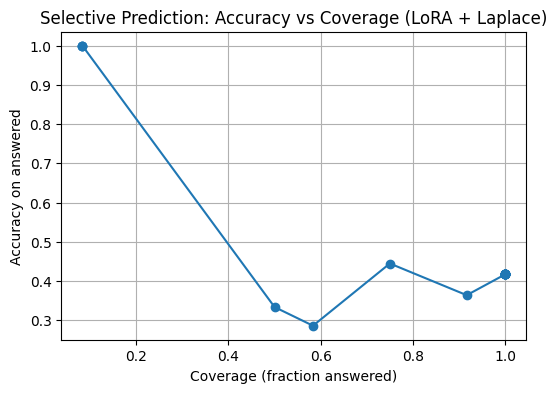

ECE=0.208, MCE=0.640


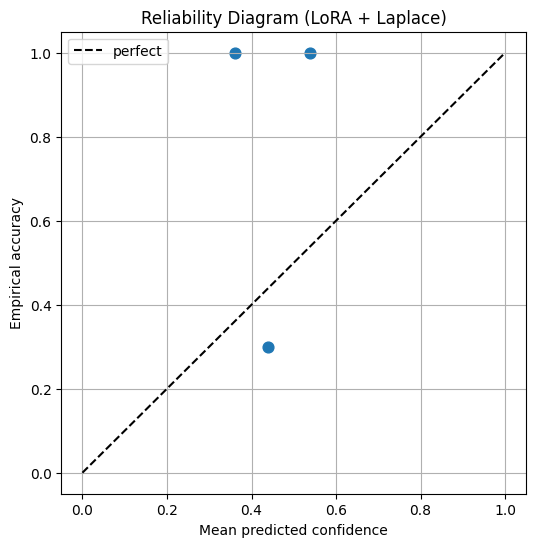

In [119]:

import numpy as np
import matplotlib.pyplot as plt

y_train = train_df['label'].values.astype(int)
y_test  = test_df['label'].values.astype(int)

acc_tr = (p_tr.argmax(axis=1) == y_train).mean()
acc_te = (p_te.argmax(axis=1) == y_test).mean()
print(f"Accuracy: train={acc_tr:.3f}, test={acc_te:.3f}")

def evaluate_with_abstention(probs, y_true, tau=0.8):
    probs = np.asarray(probs); y_true = np.asarray(y_true)
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    answered = conf >= float(tau)
    coverage = answered.mean()
    acc = float("nan") if coverage == 0 else (pred[answered] == y_true[answered]).mean()
    return coverage, acc

taus = np.linspace(0.0, 0.99, 40)
curve = np.array([evaluate_with_abstention(p_te, y_test, tau=t) for t in taus])
coverages, accs = curve[:, 0], curve[:, 1]

plt.figure(figsize=(6,4))
plt.plot(coverages, accs, marker="o")
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered")
plt.title("Selective Prediction: Accuracy vs Coverage (LoRA + Laplace)")
plt.grid(True); plt.show()

def reliability_curve(probs, y_true, bins=8):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    bin_ids = np.digitize(conf, bin_edges) - 1
    bin_acc, bin_conf, bin_count = [], [], []
    for b in range(bins):
        mask = (bin_ids == b)
        if mask.sum() > 0:
            bin_acc.append((pred[mask] == y_true[mask]).mean())
            bin_conf.append(conf[mask].mean())
            bin_count.append(mask.sum())
        else:
            bin_acc.append(np.nan); bin_conf.append(np.nan); bin_count.append(0)
    return np.array(bin_conf), np.array(bin_acc), np.array(bin_count), bin_edges

def expected_calibration_error(probs, y_true, bins=8):
    bin_conf, bin_acc, bin_cnt, _ = reliability_curve(probs, y_true, bins=bins)
    mask = ~np.isnan(bin_conf)
    weights = bin_cnt[mask] / bin_cnt[mask].sum() if bin_cnt[mask].sum()>0 else np.zeros_like(bin_cnt[mask])
    ece = np.sum(weights * np.abs(bin_acc[mask] - bin_conf[mask]))
    mce = np.max(np.abs(bin_acc[mask] - bin_conf[mask])) if mask.any() else np.nan
    return ece, mce, bin_conf, bin_acc

ece, mce, bin_conf, bin_acc = expected_calibration_error(p_te, y_test, bins=8)
print(f"ECE={ece:.3f}, MCE={mce:.3f}")

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"k--", label="perfect")
valid = ~np.isnan(bin_conf)
plt.scatter(bin_conf[valid], bin_acc[valid], s=60)
plt.xlabel("Mean predicted confidence"); plt.ylabel("Empirical accuracy")
plt.title("Reliability Diagram (LoRA + Laplace)")
plt.grid(True); plt.legend(); plt.show()



## 9) Per‑question posterior predictive (mean ± 1σ) with markers


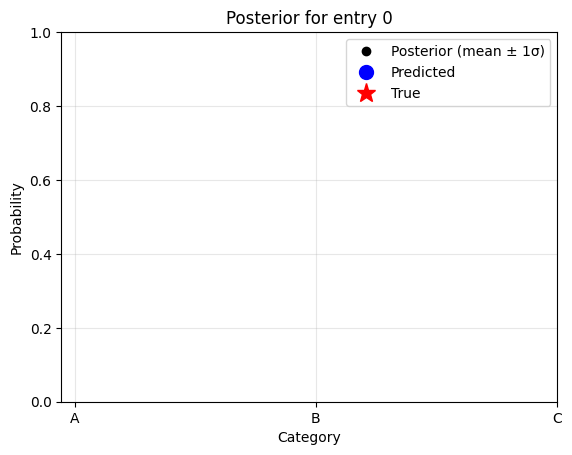

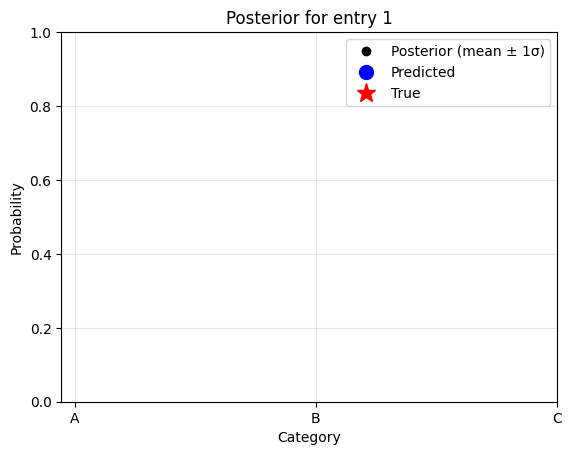

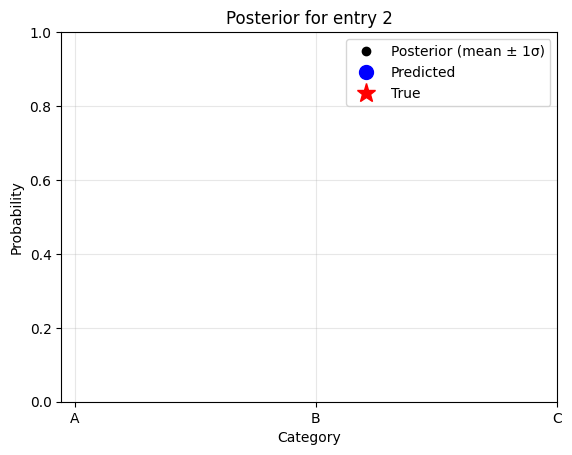

In [ ]:
from matplotlib.lines import Line2D
import numpy as np
import torch

@torch.no_grad()
def posterior_samples_for_loader(dataloader, S=50, lam=1.0):
    """
    Returns array of shape (S, N, 3) with per-sample posterior predictive probs.
    Uses the same mean-pooling and (map_idx, opt_pos) regrouping as training.
    """
    base_lora.eval(); head.eval()
    var = 1.0 / (lam * F_diag)
    std = var.sqrt()
    theta0 = pack(trainable)

    all_P = []
    for s in range(S):
        eps = torch.randn_like(std)
        theta_s = theta_map + eps * std
        set_params_from_vector(theta_s)

        probs_batches = []
        for enc, map_idx, opt_pos, gold in dataloader:
            out = base_lora(
                input_ids=enc.get("input_ids"),
                attention_mask=enc.get("attention_mask"),
                token_type_ids=enc.get("token_type_ids"),
            )
            # mean pooling with mask (same as training)
            last = out.last_hidden_state
            m = enc.get("attention_mask")
            if m is not None:
                mm = m.unsqueeze(-1).float()
                pooled = (last * mm).sum(dim=1) / mm.sum(dim=1).clamp_min(1e-6)
            else:
                pooled = last.mean(dim=1)

            scores = head(pooled).squeeze(-1)  # (B_pairs,)

            # regroup (item, option)
            N = gold.shape[0]
            scores3 = torch.full((N, 3), -1e-9, device=scores.device)
            mi = map_idx.to(scores.device)
            op = opt_pos.to(scores.device)
            scores3[mi, op] = scores

            p = torch.softmax(scores3, dim=1)  # (N, 3)
            probs_batches.append(p.detach().cpu())

        all_P.append(torch.cat(probs_batches, dim=0).numpy())

    set_params_from_vector(theta0)
    return np.stack(all_P, axis=0)  # (S, N, 3)

# cache sample-wise probs for test set
P_samps = posterior_samples_for_loader(test_loader, S=50, lam=1.0)  # (S, N, 3)
P_mean = P_samps.mean(axis=0)
P_std  = P_samps.std(axis=0)

def plot_single_event(mean, std, y_true=None, class_names=("A","B","C"), entry_id=None):
    xs = np.arange(mean.shape[0])
    plt.errorbar(xs, mean, yerr=std, fmt="none", ecolor="k", capsize=5)
    plt.plot(xs, mean, "o", color="k", markersize=6)
    y_pred = int(mean.argmax())
    plt.plot(xs[y_pred], mean[y_pred], "o", color="blue", markersize=10)
    if y_true is not None:
        plt.plot(xs[y_true], mean[y_true], marker="*", color="red", markersize=14)
    plt.xticks(xs, list(class_names)); plt.ylim(0,1); plt.ylabel("Probability"); plt.xlabel("Category")
    plt.title(f"Posterior for entry {entry_id}" if entry_id is not None else "Posterior (single question)")
    legend_elements = [
        Line2D([0],[0], marker="o", color="k",   linestyle="none", markersize=6,  label="Posterior (mean ± 1σ)"),
        Line2D([0],[0], marker="o", color="blue",linestyle="none", markersize=10, label="Predicted"),
        Line2D([0],[0], marker="*", color="red", linestyle="none", markersize=14, label="True"),
    ]
    plt.legend(handles=legend_elements, loc="best")
    plt.grid(alpha=0.3); plt.show()

# Show first 3 test examples
y_test = test_df['label'].values.astype(int)
for i in range(min(3, len(P_mean))):
    plot_single_event(P_mean[i], P_std[i], y_true=y_test[i], class_names=("A","B","C"), entry_id=i)


## 10) Notes & Next Steps

- **LoRA targets**: adjust `target_modules` depending on the backbone (e.g., `query`, `key`, `value`, `dense`, or specific module names in RoBERTa/DistilBERT).
- **λ (lam)**: try `0.1, 1.0, 5.0` to see how posterior width affects calibration/abstention.
- **Full Laplace libraries**: for research‑grade Laplace, consider `laplace-torch` (not used here to keep dependencies light).
- **Speed**: keep the model small (`bert-tiny`) and dataset tiny for quick iterations on CPU.
- **Ethical angle**: plot **accuracy vs coverage** and **reliability** to illustrate “knowing when not to answer” after Bayesianizing the LoRA adapters.
